### TESTING

In [1]:
import pandas as pd

file_path = "/content/Student Survey - Jan.xlsx"  # Adjust if needed
sheet_dict = pd.read_excel(file_path, sheet_name=None)  # Load all sheets into a dictionary

# Access individual sheets
df_affiliations = sheet_dict.get("affiliations")
df_participants = sheet_dict.get("participants")
df_responses = sheet_dict.get("responses")
df_friends = sheet_dict.get("net_0_Friends")
df_influential = sheet_dict.get("net_1_Influential")
df_feedback = sheet_dict.get("net_2_Feedback")
df_more_time = sheet_dict.get("net_3_MoreTime")
df_advice = sheet_dict.get("net_4_Advice")
df_disrespect = sheet_dict.get("net_5_Disrespect")
df_school_activity = sheet_dict.get("net_affiliation_0_SchoolActivit")

In [2]:
# --- 0. Set-up --------------------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# Modelling & evaluation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, make_scorer
)

In [3]:
# --- 2. Drop empty-target rows *and* all-NaN columns -----------------------
target_col = "Perc_Academic"
df = df.dropna(subset=[target_col])                # remove 8 unlabeled students
df = df.dropna(axis=1, how="all")                  # toss columns with no data at all

# --- 3. Train/test data ----------------------------------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns

num_pipe = Pipeline([
    ("imp",   SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
cat_pipe = Pipeline([
    ("imp",   SimpleImputer(strategy="most_frequent")),
    ("ohe",   OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

model = GradientBoostingRegressor(random_state=42)
pipe  = make_pipeline(pre, model)

# --- 4. Custom RMSE scorer for old sklearn ---------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "MAE":  make_scorer(mean_absolute_error,   greater_is_better=False),
    "RMSE": make_scorer(rmse,                  greater_is_better=False),
    "R2":   make_scorer(r2_score,              greater_is_better=True)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)

# --- 5. Pretty print (convert negative scores back to positive) ------------
print("=== 5-fold CV (baseline, no graph) ===")
for m in ["MAE", "RMSE", "R2"]:
    scores = cv_res[f"test_{m}"]
    if m in ["MAE", "RMSE"]:
        scores = -scores          # flip sign back to positive
    print(f"{m:4}: {scores.mean():6.2f} ± {scores.std():.2f}")

NameError: name 'df' is not defined

In [4]:
# 🚀 1) Make sure the runtime already has the torch you want
import torch, re, os, subprocess, sys

# Strip the "+cuXXXX" part so the tag matches the wheel index
TORCH = re.sub(r"\+.*", "", torch.__version__)        # e.g. "2.3.0"
CUDA  = torch.version.cuda or "cpu"                   # e.g. "12.1" → "121"
CUDA_TAG = "cpu" if CUDA == "cpu" else f"cu{CUDA.replace('.', '')}"

WHEEL_INDEX = f"https://data.pyg.org/whl/torch-{TORCH}+{CUDA_TAG}.html"

# 🚀 2) Install the matching wheels (quiet flag keeps logs clean)
!pip -q install torch-scatter torch-sparse torch-cluster torch-geometric -f {WHEEL_INDEX}

In [5]:
import torch, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from pathlib import Path

In [6]:
# ╒══════════════════════════════════════════════════════════════════════╕
# 1. Load workbook & merge tables
# ╘══════════════════════════════════════════════════════════════════════╛
file_path = "/content/Student Survey - Jan.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)

df_nodes = (sheets["participants"]
            .merge(sheets["responses"], on="Participant-ID", how="left",
                   suffixes=("", "_resp")))

df_nodes = df_nodes.dropna(subset=["Perc_Academic"])   # keep only labelled nodes
node_ids = df_nodes["Participant-ID"].to_numpy()

# ╒══════════════════════════════════════════════════════════════════════╕
# 2. Tabular preprocessing -> numpy feature matrix X (standardised)
# ╘══════════════════════════════════════════════════════════════════════╛
target = df_nodes.pop("Perc_Academic").to_numpy().astype("float32")
df_nodes = df_nodes.dropna(axis=1, how="all")          # drop entirely empty cols

num_cols = df_nodes.select_dtypes(["int64", "float64"]).columns
cat_cols = df_nodes.select_dtypes(["object", "category", "bool"]).columns

pre = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("std", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
      ])

X = pre.fit_transform(df_nodes).astype("float32")       # shape (N,F)

# ╒══════════════════════════════════════════════════════════════════════╕
# 3. Combine SIX directed edge sheets into one COO edge_index
# ╘══════════════════════════════════════════════════════════════════════╛
edge_frames = [sheets[k] for k in ["net_0_Friends", "net_1_Influential",
                                   "net_2_Feedback", "net_3_MoreTime",
                                   "net_4_Advice", "net_5_Disrespect"]]

edge_df = pd.concat(edge_frames)[["Source", "Target"]].dropna()
# Map raw IDs → 0..N-1 indices (only those present in df_nodes)
id2idx = {pid: i for i, pid in enumerate(node_ids)}
edge_df = edge_df[edge_df["Source"].isin(id2idx) & edge_df["Target"].isin(id2idx)]
src = edge_df["Source"].map(id2idx).to_numpy()
dst = edge_df["Target"].map(id2idx).to_numpy()
edge_index = torch.from_numpy(np.vstack([src, dst])).long()   # [2, E]

# ╒══════════════════════════════════════════════════════════════════════╕
# 4. Build PyG Data object
# ╘══════════════════════════════════════════════════════════════════════╛
X_dense = pre.fit_transform(df_nodes).astype("float32").toarray()  # or .A
data = Data(
    x=torch.from_numpy(X_dense),
    y=torch.from_numpy(target),
    edge_index=edge_index
)

# ╒══════════════════════════════════════════════════════════════════════╕
# 5. Train / val / test node masks
# ╘══════════════════════════════════════════════════════════════════════╛
idx = np.arange(data.num_nodes)
train_idx, temp_idx = train_test_split(idx, test_size=0.30, random_state=42)
val_idx,  test_idx = train_test_split(temp_idx, test_size=0.50, random_state=42)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask   = torch.zeros_like(data.train_mask)
data.test_mask  = torch.zeros_like(data.train_mask)
data.train_mask[train_idx] = True
data.val_mask[val_idx]     = True
data.test_mask[test_idx]   = True

# ╒══════════════════════════════════════════════════════════════════════╕
# 6. Two-layer GCN model
# ╘══════════════════════════════════════════════════════════════════════╛
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid=64, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid)
        self.conv2 = GCNConv(hid, hid)
        self.lin   = torch.nn.Linear(hid, 1)
        self.dp    = torch.nn.Dropout(dropout)
    def forward(self, data):
        x = torch.relu(self.conv1(data.x, data.edge_index))
        x = self.dp(x)
        x = torch.relu(self.conv2(x, data.edge_index))
        return self.lin(x).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN(in_dim=data.num_node_features).to(device)
data  = data.to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

# ╒══════════════════════════════════════════════════════════════════════╕
# 7. Training loop with early-stop on val RMSE
# ╘══════════════════════════════════════════════════════════════════════╛
best_rmse = float("inf"); patience = 30; counter = 0
for epoch in range(1, 401):
    model.train()
    opt.zero_grad()

    pred  = model(data)
    loss  = loss_fn(pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    opt.step()

    # ── validation ──
    model.eval()
    with torch.no_grad():
        val_pred = model(data)[data.val_mask].cpu()
    val_rmse = np.sqrt(mean_squared_error(
        data.y[data.val_mask].cpu(), val_pred))

    if val_rmse < best_rmse - 1e-3:
        best_rmse, counter = val_rmse, 0
        torch.save(model.state_dict(), "best.pt")
    else:
        counter += 1
    if counter >= patience:
        break

# ╒══════════════════════════════════════════════════════════════════════╕
# 8. Test metrics
# ╘══════════════════════════════════════════════════════════════════════╛
model.load_state_dict(torch.load("best.pt"))
model.eval()
with torch.no_grad():
    y_hat = model(data).cpu().numpy()

test_true = data.y[data.test_mask].cpu().numpy()
test_pred = y_hat[data.test_mask.cpu().numpy()]

print("\n=== Homogeneous GCN on union graph ===")
print(f"MAE : {mean_absolute_error(test_true, test_pred):5.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(test_true, test_pred)):5.2f}")
print(f"R²  : {r2_score(test_true, test_pred):5.2f}")


=== Homogeneous GCN on union graph ===
MAE : 14.89
RMSE: 18.87
R²  : -0.26


In [26]:
import torch, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from pathlib import Path

# ╒══════════════════════════════════════════════════════════════════════╕
# 1. Load workbook & node table
# ╘══════════════════════════════════════════════════════════════════════╛
file_path = "/content/Student Survey - Jan.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
df_nodes = (sheets["participants"]
            .merge(sheets["responses"], on="Participant-ID", how="left",
                   suffixes=("", "_resp")))
df_nodes = df_nodes.dropna(subset=["Perc_Academic"])      # keep only labelled

# ╒══════════════════════════════════════════════════════════════════════╕
# 2. Tabular preprocessing ➜ numpy feature matrix
# ╘══════════════════════════════════════════════════════════════════════╛
y = df_nodes.pop("Perc_Academic").to_numpy().astype("float32")
df_nodes = df_nodes.dropna(axis=1, how="all")             # drop empty columns

num_cols = df_nodes.select_dtypes(["int64", "float64"]).columns
cat_cols = df_nodes.select_dtypes(["object", "category", "bool"]).columns

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        # ↓ set sparse_output=False (sklearn ≥1.2) or sparse=False (≤1.1)
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

X = pre.fit_transform(df_nodes).astype("float32")   # now a NumPy ndarray

# ╒══════════════════════════════════════════════════════════════════════╕
# 3. Build HeteroData with **six relations + reverse edges**
# ╘══════════════════════════════════════════════════════════════════════╛
pid_arr = df_nodes["Participant-ID"].to_numpy()
pid2idx = {pid: i for i, pid in enumerate(pid_arr)}

data = HeteroData()
data["student"].x = torch.from_numpy(X)
data["student"].y = torch.from_numpy(y)

edge_sheets = {
    "friends"     : "net_0_Friends",
    "influential" : "net_1_Influential",
    "feedback"    : "net_2_Feedback",
    "moretime"    : "net_3_MoreTime",
    "advice"      : "net_4_Advice",
    "disrespect"  : "net_5_Disrespect"
}

for rel, sheet_name in edge_sheets.items():
    df_e = sheets[sheet_name][["Source", "Target"]].dropna()
    mask = df_e["Source"].isin(pid2idx) & df_e["Target"].isin(pid2idx)
    src = df_e.loc[mask, "Source"].map(pid2idx).to_numpy()
    dst = df_e.loc[mask, "Target"].map(pid2idx).to_numpy()
    if len(src) == 0:             # skip empty relations
        continue
    ei = torch.tensor([src, dst], dtype=torch.long)
    data["student", rel, "student"].edge_index = ei
    # add explicit reverse relation to aid message flow
    data["student", f"{rel}_rev", "student"].edge_index = ei.flip(0)

# ╒══════════════════════════════════════════════════════════════════════╕
# 4. Masks
# ╘══════════════════════════════════════════════════════════════════════╛
from sklearn.model_selection import StratifiedShuffleSplit
seed = 42
bins = pd.qcut(y, q=4, labels=False, duplicates="drop")
sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
train_idx, tmp_idx = next(sss.split(np.arange(len(y)), bins))

# split the remaining 30 % in half (stratified)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
val_idx, test_idx = next(sss2.split(tmp_idx, bins[tmp_idx]))

# build boolean masks
for name, idx_arr in [("train_mask", train_idx),
                      ("val_mask",   val_idx),
                      ("test_mask",  test_idx)]:
    mask = torch.zeros(data["student"].num_nodes, dtype=torch.bool)
    mask[idx_arr] = True
    data["student"][name] = mask

# ╒══════════════════════════════════════════════════════════════════════╕
# 5. 2-layer Relational GAT
# ╘══════════════════════════════════════════════════════════════════════╛
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class RGAT(torch.nn.Module):
    def __init__(self, metadata, in_dim, hid=64, heads=3, dropout=0.1):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, hid)

        self.convs = torch.nn.ModuleList()
        for _ in range(2):
            conv_dict = {
                et: GATConv(
                    (-1, -1),
                    32,
                    heads=heads,
                    concat=True,
                    dropout=0.2,
                    add_self_loops=False         # ← keep this
                    # edge_dropout=0.2  ← remove / comment out
                    )
                for et in metadata[1]
}
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))

        self.lin_out = torch.nn.Linear(32 * heads, 1)   # 32×3 → 1
        self.dp = torch.nn.Dropout(dropout)

    def forward(self, data):
        x_dict = {"student": torch.relu(self.lin_in(data["student"].x))}
        for conv in self.convs:
            x_dict = conv(x_dict, data.edge_index_dict)
            x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
            x_dict = {k: self.dp(v)    for k, v in x_dict.items()}
        return self.lin_out(x_dict["student"]).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
data = data.to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

# ╒══════════════════════════════════════════════════════════════════════╕
# 6. Training with early stopping on val RMSE
# ╘══════════════════════════════════════════════════════════════════════╛
best_rmse, patience, wait = float("inf"), 30, 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=10
)

for epoch in range(1, 401):
    model.train()
    opt.zero_grad()

    out  = model(data)
    loss = loss_fn(out[data["student"].train_mask],
                   data["student"].y[data["student"].train_mask])
    loss.backward()
    opt.step()

    # ── validation ──
    model.eval()
    with torch.no_grad():
        val_pred = model(data)[data["student"].val_mask].cpu()
    val_rmse = np.sqrt(
        mean_squared_error(data["student"].y[data["student"].val_mask].cpu(),
                           val_pred)
    )

    # step the LR scheduler **after** computing val_rmse
    scheduler.step(val_rmse)

    # early-stop bookkeeping
    if val_rmse + 1e-3 < best_rmse:
        best_rmse, wait = val_rmse, 0
        torch.save(model.state_dict(), "rgat_best.pt")
    else:
        wait += 1
    if wait >= patience:
        break

# ╒══════════════════════════════════════════════════════════════════════╕
# 7. Test metrics
# ╘══════════════════════════════════════════════════════════════════════╛
model.load_state_dict(torch.load("rgat_best.pt"))
model.eval()
with torch.no_grad():
    preds = model(data).cpu().numpy()

y_true = data["student"].y[data["student"].test_mask].cpu().numpy()
y_pred = preds[data["student"].test_mask.cpu().numpy()]

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("\n=== Relational GAT (6 edge types) ===")
print(f"MAE : {mae:5.2f}")
print(f"RMSE: {rmse:5.2f}")
print(f"R²  : {r2:5.2f}")


=== Relational GAT (6 edge types) ===
MAE : 11.35
RMSE: 13.54
R²  :  0.55


### BEST SETUP

In [56]:
import torch, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from pathlib import Path

# ╒══════════════════════════════════════════════════════════════════════╕
# 1. Load workbook & node table
# ╘══════════════════════════════════════════════════════════════════════╛
file_path = "/content/Student Survey - Jan.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
df_nodes = (sheets["participants"]
            .merge(sheets["responses"], on="Participant-ID", how="left",
                   suffixes=("", "_resp")))
df_nodes = df_nodes.dropna(subset=["Perc_Academic"])      # keep only labelled

# ╒══════════════════════════════════════════════════════════════════════╕
# 2. Tabular preprocessing ➜ numpy feature matrix
# ╘══════════════════════════════════════════════════════════════════════╛
# 2-a.  Label-aware normalisation  (z-score within House)
df_nodes["House"] = df_nodes["House"].astype("category")
mu  = df_nodes.groupby("House")["Perc_Academic"].transform("mean")
std = df_nodes.groupby("House")["Perc_Academic"].transform("std").clip(lower=1e-6)
y_raw = df_nodes["Perc_Academic"].to_numpy(dtype="float32")        # keep raw
y     = ((y_raw - mu) / std).to_numpy(dtype="float32")             # scaled

# 2-b.  *now* drop the target so it isn’t used as an input feature
df_nodes = df_nodes.drop(columns=["Perc_Academic"])
df_nodes = df_nodes.dropna(axis=1, how="all")             # drop empty columns

num_cols = df_nodes.select_dtypes(["int64", "float64"]).columns
cat_cols = df_nodes.select_dtypes(["object", "category", "bool"]).columns

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        # ↓ set sparse_output=False (sklearn ≥1.2) or sparse=False (≤1.1)
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

X = pre.fit_transform(df_nodes).astype("float32")   # now a NumPy ndarray

# ╒══════════════════════════════════════════════════════════════════════╕
# 3. Build HeteroData with **six relations + reverse edges**
# ╘══════════════════════════════════════════════════════════════════════╛
pid_arr = df_nodes["Participant-ID"].to_numpy()
pid2idx = {pid: i for i, pid in enumerate(pid_arr)}

data = HeteroData()
data["student"].x = torch.from_numpy(X)
data["student"].y = torch.from_numpy(y)

edge_sheets = {
    "friends"     : "net_0_Friends",
    "influential" : "net_1_Influential",
    "feedback"    : "net_2_Feedback",
    "moretime"    : "net_3_MoreTime",
    "advice"      : "net_4_Advice",
    "disrespect"  : "net_5_Disrespect"
}

for rel, sheet_name in edge_sheets.items():
    df_e = sheets[sheet_name][["Source", "Target"]].dropna()
    mask = df_e["Source"].isin(pid2idx) & df_e["Target"].isin(pid2idx)
    src = df_e.loc[mask, "Source"].map(pid2idx).to_numpy()
    dst = df_e.loc[mask, "Target"].map(pid2idx).to_numpy()
    if len(src) == 0:             # skip empty relations
        continue
    ei = torch.tensor([src, dst], dtype=torch.long)
    data["student", rel, "student"].edge_index = ei
    # add explicit reverse relation to aid message flow
    data["student", f"{rel}_rev", "student"].edge_index = ei.flip(0)

# ╒══════════════════════════════════════════════════════════════════════╕
# 4. Masks
# ╘══════════════════════════════════════════════════════════════════════╛
from sklearn.model_selection import StratifiedShuffleSplit
seed = 42
bins = pd.qcut(y, q=4, labels=False, duplicates="drop")
sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
train_idx, tmp_idx = next(sss.split(np.arange(len(y)), bins))

# split the remaining 30 % in half (stratified)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
val_idx, test_idx = next(sss2.split(tmp_idx, bins[tmp_idx]))

# build boolean masks
for name, idx_arr in [("train_mask", train_idx),
                      ("val_mask",   val_idx),
                      ("test_mask",  test_idx)]:
    mask = torch.zeros(data["student"].num_nodes, dtype=torch.bool)
    mask[idx_arr] = True
    data["student"][name] = mask

# ╒══════════════════════════════════════════════════════════════════════╕
# 5. 2-layer Relational GAT
# ╘══════════════════════════════════════════════════════════════════════╛
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class RGAT(torch.nn.Module):
    def __init__(self, metadata, in_dim, hid=64, heads=3, dropout=0.1):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, hid)

        self.convs = torch.nn.ModuleList()
        for _ in range(2):
            conv_dict = {
                et: GATConv(
                    (-1, -1),
                    32,
                    heads=heads,
                    concat=True,
                    dropout=0.2,
                    add_self_loops=False         # ← keep this
                    # edge_dropout=0.2  ← remove / comment out
                    )
                for et in metadata[1]
}
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))

        self.lin_out = torch.nn.Linear(32 * heads, 1)   # 32×3 → 1
        self.dp = torch.nn.Dropout(dropout)

    def forward(self, data):
        x_dict = {"student": torch.relu(self.lin_in(data["student"].x))}
        for conv in self.convs:
            x_dict = conv(x_dict, data.edge_index_dict)
            x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
            x_dict = {k: self.dp(v)    for k, v in x_dict.items()}
        return self.lin_out(x_dict["student"]).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
data = data.to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

#  (everything up to HeteroData stays the same, except use y not y_raw)

# ===================================================================
#  B.  tiny grid search: depth ∈ {2,3}, heads ∈ {2–6}, dropout ∈ {0–0.4}
# ===================================================================
hyper_grid = {
    "depth":   [2, 3],
    "heads":   [2, 3, 4, 5, 6],
    "dropout": [0.0, 0.1, 0.2, 0.3, 0.4],
}
best_val = float("inf")
best_cfg, best_state = None, None

for depth in hyper_grid["depth"]:
    for heads in hyper_grid["heads"]:
        for dp in hyper_grid["dropout"]:
            torch.manual_seed(seed)           # reproducible per run
            np.random.seed(seed)

            # -- define RGAT with variable depth / heads / dropout ----
            class RGAT(torch.nn.Module):
                def __init__(self, metadata, in_dim):
                    super().__init__()
                    self.lin_in = torch.nn.Linear(in_dim, 64)
                    self.convs = torch.nn.ModuleList()
                    for _ in range(depth):
                        conv_dict = {
                            et: GATConv((-1, -1), 32,
                                        heads=heads, concat=True,
                                        dropout=dp, add_self_loops=False)
                            for et in metadata[1]
                        }
                        self.convs.append(HeteroConv(conv_dict, aggr="mean"))
                    self.lin_out = torch.nn.Linear(32 * heads, 1)
                    self.dp = torch.nn.Dropout(dp)

                def forward(self, d):
                    x = {"student": torch.relu(self.lin_in(d["student"].x))}
                    for conv in self.convs:
                        x = conv(x, d.edge_index_dict)
                        x = {k: torch.relu(v) for k, v in x.items()}
                        x = {k: self.dp(v)    for k, v in x.items()}
                    return self.lin_out(x["student"]).squeeze()

            model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
            opt   = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
            sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min",
                                                               factor=0.5, patience=10)
            best_rmse, wait = float("inf"), 0
            for epoch in range(1, 401):
                model.train(); opt.zero_grad()
                out  = model(data)
                loss = loss_fn(out[data["student"].train_mask],
                               data["student"].y[data["student"].train_mask])
                loss.backward(); opt.step()

                # validation
                model.eval()
                with torch.no_grad():
                    v_pred = model(data)[data["student"].val_mask].cpu()
                v_rmse = np.sqrt(mean_squared_error(
                    data["student"].y[data["student"].val_mask].cpu(), v_pred))
                sched.step(v_rmse)

                if v_rmse + 1e-3 < best_rmse:
                    best_rmse, wait = v_rmse, 0
                    best_state = model.state_dict()
                else:
                    wait += 1
                if wait >= 30:               # early stop
                    break

            # keep global best
            if best_rmse < best_val:
                best_val, best_cfg = best_rmse, (depth, heads, dp)
                torch.save(best_state, "rgat_best_overall.pt")

print(f"Best config depth={best_cfg[0]} heads={best_cfg[1]} dropout={best_cfg[2]:.1f}"
      f"  |  val-RMSE={best_val:5.2f}")

# ===================================================================
#  C.  final test metrics on best model
# ===================================================================
# ── rebuild model with the winning hyper-params ─────────────────────
best_depth, best_heads, best_dp = best_cfg
class RGAT_Best(torch.nn.Module):
    def __init__(self, metadata, in_dim):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, 64)
        self.convs  = torch.nn.ModuleList()
        for _ in range(best_depth):
            conv_dict = {
                et: GATConv((-1, -1), 32,
                            heads=best_heads, concat=True,
                            dropout=best_dp, add_self_loops=False)
                for et in metadata[1]
            }
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))
        self.lin_out = torch.nn.Linear(32 * best_heads, 1)
        self.dp = torch.nn.Dropout(best_dp)

    def forward(self, d):
        x = {"student": torch.relu(self.lin_in(d["student"].x))}
        for conv in self.convs:
            x = conv(x, d.edge_index_dict)
            x = {k: torch.relu(v) for k, v in x.items()}
            x = {k: self.dp(v)    for k, v in x.items()}
        return self.lin_out(x["student"]).squeeze()

model = RGAT_Best(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
model.load_state_dict(torch.load("rgat_best_overall.pt"), strict=False)
model.eval()

# ── test inference ───────────────────────────────────────────────────
with torch.no_grad():
    y_hat_scaled = model(data).cpu().numpy()

# un-scale back to raw GPA units
y_hat = y_hat_scaled * std.to_numpy() + mu.to_numpy()

test_mask = data["student"].test_mask.cpu().numpy()
mae  = mean_absolute_error(y_raw[test_mask], y_hat[test_mask])
rmse = np.sqrt(mean_squared_error(y_raw[test_mask], y_hat[test_mask]))
r2   = r2_score(y_raw[test_mask], y_hat[test_mask])

print("\n=== RGAT  (grid-tuned, label-normalised) ===")
print(f"MAE : {mae:5.2f}")
print(f"RMSE: {rmse:5.2f}")
print(f"R²  : {r2:5.2f}")

Best config depth=2 heads=2 dropout=0.0  |  val-RMSE= 0.52

=== RGAT  (grid-tuned, label-normalised) ===
MAE :  2.35
RMSE:  7.81
R²  :  0.82


### TESTING

In [61]:
import torch, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from pathlib import Path

# ╒══════════════════════════════════════════════════════════════════════╕
# 1. Load workbook & node table
# ╘══════════════════════════════════════════════════════════════════════╛
file_path = "/content/Student Survey - July.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
df_nodes = (sheets["participantsNov"]
            .merge(sheets["responses"], on="Participant-ID", how="left",
                   suffixes=("", "_resp")))
df_nodes = df_nodes.dropna(subset=["Perc_Academic"])      # keep only labelled

# ╒══════════════════════════════════════════════════════════════════════╕
# 2. Tabular preprocessing ➜ numpy feature matrix
# ╘══════════════════════════════════════════════════════════════════════╛
# 2-a.  Label-aware normalisation  (z-score within House)
df_nodes["House"] = df_nodes["House"].astype("category")
mu  = df_nodes.groupby("House")["Perc_Academic"].transform("mean")
std = df_nodes.groupby("House")["Perc_Academic"].transform("std").clip(lower=1e-6)
y_raw = df_nodes["Perc_Academic"].to_numpy(dtype="float32")        # keep raw
y     = ((y_raw - mu) / std).to_numpy(dtype="float32")             # scaled

# 2-b.  *now* drop the target so it isn’t used as an input feature
df_nodes = df_nodes.drop(columns=["Perc_Academic"])
df_nodes = df_nodes.dropna(axis=1, how="all")             # drop empty columns

num_cols = df_nodes.select_dtypes(["int64", "float64"]).columns
cat_cols = df_nodes.select_dtypes(["object", "category", "bool"]).columns

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        # ↓ set sparse_output=False (sklearn ≥1.2) or sparse=False (≤1.1)
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

X = pre.fit_transform(df_nodes).astype("float32")   # now a NumPy ndarray

# ╒══════════════════════════════════════════════════════════════════════╕
# 3. Build HeteroData with **six relations + reverse edges**
# ╘══════════════════════════════════════════════════════════════════════╛
pid_arr = df_nodes["Participant-ID"].to_numpy()
pid2idx = {pid: i for i, pid in enumerate(pid_arr)}

data = HeteroData()
data["student"].x = torch.from_numpy(X)
data["student"].y = torch.from_numpy(y)

edge_sheets = {
    "friends"     : "net_0_Friends",
    "influential" : "net_1_Influential",
    "feedback"    : "net_2_Feedback",
    "moretime"    : "net_3_MoreTime",
    "advice"      : "net_4_Advice",
    "disrespect"  : "net_5_Disrespect"
}

for rel, sheet_name in edge_sheets.items():
    df_e = sheets[sheet_name][["Source", "Target"]].dropna()
    mask = df_e["Source"].isin(pid2idx) & df_e["Target"].isin(pid2idx)
    src = df_e.loc[mask, "Source"].map(pid2idx).to_numpy()
    dst = df_e.loc[mask, "Target"].map(pid2idx).to_numpy()
    if len(src) == 0:             # skip empty relations
        continue
    ei = torch.tensor([src, dst], dtype=torch.long)
    data["student", rel, "student"].edge_index = ei
    # add explicit reverse relation to aid message flow
    data["student", f"{rel}_rev", "student"].edge_index = ei.flip(0)

# ╒══════════════════════════════════════════════════════════════════════╕
# 4. Masks
# ╘══════════════════════════════════════════════════════════════════════╛
from sklearn.model_selection import StratifiedShuffleSplit
seed = 42
bins = pd.qcut(y, q=4, labels=False, duplicates="drop")
sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
train_idx, tmp_idx = next(sss.split(np.arange(len(y)), bins))

# split the remaining 30 % in half (stratified)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
val_idx, test_idx = next(sss2.split(tmp_idx, bins[tmp_idx]))

# build boolean masks
for name, idx_arr in [("train_mask", train_idx),
                      ("val_mask",   val_idx),
                      ("test_mask",  test_idx)]:
    mask = torch.zeros(data["student"].num_nodes, dtype=torch.bool)
    mask[idx_arr] = True
    data["student"][name] = mask

# ╒══════════════════════════════════════════════════════════════════════╕
# 5. 2-layer Relational GAT
# ╘══════════════════════════════════════════════════════════════════════╛
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class RGAT(torch.nn.Module):
    def __init__(self, metadata, in_dim, hid=64, heads=3, dropout=0.1):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, hid)

        self.convs = torch.nn.ModuleList()
        for _ in range(2):
            conv_dict = {
                et: GATConv(
                    (-1, -1),
                    32,
                    heads=heads,
                    concat=True,
                    dropout=0.2,
                    add_self_loops=False         # ← keep this
                    # edge_dropout=0.2  ← remove / comment out
                    )
                for et in metadata[1]
}
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))

        self.lin_out = torch.nn.Linear(32 * heads, 1)   # 32×3 → 1
        self.dp = torch.nn.Dropout(dropout)

    def forward(self, data):
        x_dict = {"student": torch.relu(self.lin_in(data["student"].x))}
        for conv in self.convs:
            x_dict = conv(x_dict, data.edge_index_dict)
            x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
            x_dict = {k: self.dp(v)    for k, v in x_dict.items()}
        return self.lin_out(x_dict["student"]).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
data = data.to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

#  (everything up to HeteroData stays the same, except use y not y_raw)

# ===================================================================
#  B.  tiny grid search: depth ∈ {2,3}, heads ∈ {2–6}, dropout ∈ {0–0.4}
# ===================================================================
hyper_grid = {
    "depth":   [2, 3],
    "heads":   [2, 3, 4, 5, 6],
    "dropout": [0.0, 0.1, 0.2, 0.3, 0.4],
}
best_val = float("inf")
best_cfg, best_state = None, None

for depth in hyper_grid["depth"]:
    for heads in hyper_grid["heads"]:
        for dp in hyper_grid["dropout"]:
            torch.manual_seed(seed)           # reproducible per run
            np.random.seed(seed)

            # -- define RGAT with variable depth / heads / dropout ----
            class RGAT(torch.nn.Module):
                def __init__(self, metadata, in_dim):
                    super().__init__()
                    self.lin_in = torch.nn.Linear(in_dim, 64)
                    self.convs = torch.nn.ModuleList()
                    for _ in range(depth):
                        conv_dict = {
                            et: GATConv((-1, -1), 32,
                                        heads=heads, concat=True,
                                        dropout=dp, add_self_loops=False)
                            for et in metadata[1]
                        }
                        self.convs.append(HeteroConv(conv_dict, aggr="mean"))
                    self.lin_out = torch.nn.Linear(32 * heads, 1)
                    self.dp = torch.nn.Dropout(dp)

                def forward(self, d):
                    x = {"student": torch.relu(self.lin_in(d["student"].x))}
                    for conv in self.convs:
                        x = conv(x, d.edge_index_dict)
                        x = {k: torch.relu(v) for k, v in x.items()}
                        x = {k: self.dp(v)    for k, v in x.items()}
                    return self.lin_out(x["student"]).squeeze()

            model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
            opt   = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
            sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min",
                                                               factor=0.5, patience=10)
            best_rmse, wait = float("inf"), 0
            for epoch in range(1, 401):
                model.train(); opt.zero_grad()
                out  = model(data)
                loss = loss_fn(out[data["student"].train_mask],
                               data["student"].y[data["student"].train_mask])
                loss.backward(); opt.step()

                # validation
                model.eval()
                with torch.no_grad():
                    v_pred = model(data)[data["student"].val_mask].cpu()
                v_rmse = np.sqrt(mean_squared_error(
                    data["student"].y[data["student"].val_mask].cpu(), v_pred))
                sched.step(v_rmse)

                if v_rmse + 1e-3 < best_rmse:
                    best_rmse, wait = v_rmse, 0
                    best_state = model.state_dict()
                else:
                    wait += 1
                if wait >= 30:               # early stop
                    break

            # keep global best
            if best_rmse < best_val:
                best_val, best_cfg = best_rmse, (depth, heads, dp)
                torch.save(best_state, "rgat_best_overall.pt")

print(f"Best config depth={best_cfg[0]} heads={best_cfg[1]} dropout={best_cfg[2]:.1f}"
      f"  |  val-RMSE={best_val:5.2f}")

# ===================================================================
#  C.  final test metrics on best model
# ===================================================================
# ── rebuild model with the winning hyper-params ─────────────────────
best_depth, best_heads, best_dp = best_cfg
class RGAT_Best(torch.nn.Module):
    def __init__(self, metadata, in_dim):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, 64)
        self.convs  = torch.nn.ModuleList()
        for _ in range(best_depth):
            conv_dict = {
                et: GATConv((-1, -1), 32,
                            heads=best_heads, concat=True,
                            dropout=best_dp, add_self_loops=False)
                for et in metadata[1]
            }
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))
        self.lin_out = torch.nn.Linear(32 * best_heads, 1)
        self.dp = torch.nn.Dropout(best_dp)

    def forward(self, d):
        x = {"student": torch.relu(self.lin_in(d["student"].x))}
        for conv in self.convs:
            x = conv(x, d.edge_index_dict)
            x = {k: torch.relu(v) for k, v in x.items()}
            x = {k: self.dp(v)    for k, v in x.items()}
        return self.lin_out(x["student"]).squeeze()

model = RGAT_Best(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
model.load_state_dict(torch.load("rgat_best_overall.pt"), strict=False)
model.eval()

# ── test inference ───────────────────────────────────────────────────
with torch.no_grad():
    y_hat_scaled = model(data).cpu().numpy()

# un-scale back to raw GPA units
y_hat = y_hat_scaled * std.to_numpy() + mu.to_numpy()

test_mask = data["student"].test_mask.cpu().numpy()
mae  = mean_absolute_error(y_raw[test_mask], y_hat[test_mask])
rmse = np.sqrt(mean_squared_error(y_raw[test_mask], y_hat[test_mask]))
r2   = r2_score(y_raw[test_mask], y_hat[test_mask])

print("\n=== RGAT  (grid-tuned, label-normalised) ===")
print(f"MAE : {mae:5.2f}")
print(f"RMSE: {rmse:5.2f}")
print(f"R²  : {r2:5.2f}")

Best config depth=2 heads=6 dropout=0.3  |  val-RMSE= 0.41

=== RGAT  (grid-tuned, label-normalised) ===
MAE : 10.52
RMSE: 15.60
R²  :  0.56


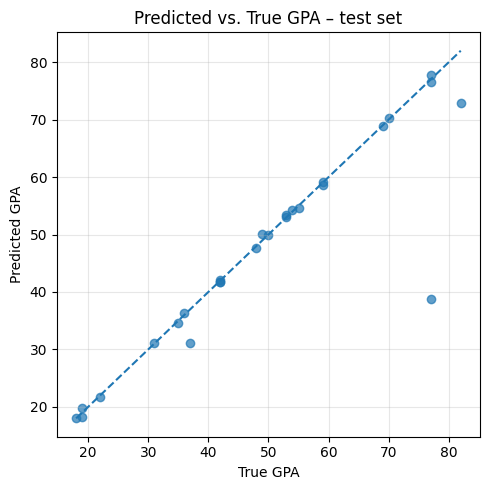


Absolute-error by House


,count,mean,std
House,,,
Phoenix,6,0.245176,0.163006
Falcon,5,0.369793,0.202822
Griffin,3,0.505822,0.511617
Astral,6,1.221107,2.324175
Vanguard,3,3.299186,5.015326
Redwood,3,13.042629,21.844654


In [57]:
# ── Diagnostics: quality checks ─────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1) scatter: predicted vs true (test set)
true_test = y_raw[test_mask]        # ground-truth GPA
pred_test = y_hat[test_mask]        # model predictions (back-scaled)

plt.figure(figsize=(5,5))
plt.scatter(true_test, pred_test, alpha=0.7)
lims = [min(true_test.min(), pred_test.min()),
        max(true_test.max(), pred_test.max())]
plt.plot(lims, lims, linestyle="--")       # identity line
plt.xlabel("True GPA");  plt.ylabel("Predicted GPA")
plt.title("Predicted vs. True GPA – test set")
plt.grid(alpha=.3);  plt.tight_layout()
plt.show()

# 2) absolute-error per House
house_test = df_nodes.loc[test_mask, "House"].astype(str)
abs_err    = np.abs(true_test - pred_test)

per_house = (pd.DataFrame({"House": house_test, "abs_err": abs_err})
               .groupby("House")["abs_err"]
               .agg(count="size", mean="mean", std="std")
               .sort_values("mean"))

print("\nAbsolute-error by House")
display(per_house)

In [33]:
import torch, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from pathlib import Path

# ╒══════════════════════════════════════════════════════════════════════╕
# 1. Load workbook & node table
# ╘══════════════════════════════════════════════════════════════════════╛
file_path = "/content/Student Survey - Jan.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
df_nodes = (sheets["participants"]
            .merge(sheets["responses"], on="Participant-ID", how="left",
                   suffixes=("", "_resp")))
df_nodes = df_nodes.dropna(subset=["Perc_Academic"])      # keep only labelled

# ╒══════════════════════════════════════════════════════════════════════╕
# 2. Tabular preprocessing ➜ numpy feature matrix
# ╘══════════════════════════════════════════════════════════════════════╛
y = df_nodes.pop("Perc_Academic").to_numpy().astype("float32")
df_nodes = df_nodes.dropna(axis=1, how="all")             # drop empty columns

num_cols = df_nodes.select_dtypes(["int64", "float64"]).columns
cat_cols = df_nodes.select_dtypes(["object", "category", "bool"]).columns

pre = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        # ↓ set sparse_output=False (sklearn ≥1.2) or sparse=False (≤1.1)
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])

X = pre.fit_transform(df_nodes).astype("float32")   # now a NumPy ndarray

# ╒══════════════════════════════════════════════════════════════════════╕
# 3. Build HeteroData with **six relations + reverse edges**
# ╘══════════════════════════════════════════════════════════════════════╛
pid_arr = df_nodes["Participant-ID"].to_numpy()
pid2idx = {pid: i for i, pid in enumerate(pid_arr)}

data = HeteroData()
data["student"].x = torch.from_numpy(X)
data["student"].y = torch.from_numpy(y)

edge_sheets = {
    "feedback" : "net_2_Feedback",
    "moretime" : "net_3_MoreTime",
    "advice"   : "net_4_Advice",
}

for rel, sheet_name in edge_sheets.items():
    df_e = sheets[sheet_name][["Source", "Target"]].dropna()
    mask = df_e["Source"].isin(pid2idx) & df_e["Target"].isin(pid2idx)
    src = df_e.loc[mask, "Source"].map(pid2idx).to_numpy()
    dst = df_e.loc[mask, "Target"].map(pid2idx).to_numpy()
    if len(src) == 0:             # skip empty relations
        continue
    ei = torch.tensor([src, dst], dtype=torch.long)
    data["student", rel, "student"].edge_index = ei
    # add explicit reverse relation to aid message flow
    data["student", f"{rel}_rev", "student"].edge_index = ei.flip(0)

# ╒══════════════════════════════════════════════════════════════════════╕
# 4. Masks
# ╘══════════════════════════════════════════════════════════════════════╛
from sklearn.model_selection import StratifiedShuffleSplit
seed = 42
bins = pd.qcut(y, q=4, labels=False, duplicates="drop")
sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
train_idx, tmp_idx = next(sss.split(np.arange(len(y)), bins))

# split the remaining 30 % in half (stratified)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
val_idx, test_idx = next(sss2.split(tmp_idx, bins[tmp_idx]))

# build boolean masks
for name, idx_arr in [("train_mask", train_idx),
                      ("val_mask",   val_idx),
                      ("test_mask",  test_idx)]:
    mask = torch.zeros(data["student"].num_nodes, dtype=torch.bool)
    mask[idx_arr] = True
    data["student"][name] = mask

# ╒══════════════════════════════════════════════════════════════════════╕
# 5. 2-layer Relational GAT
# ╘══════════════════════════════════════════════════════════════════════╛
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class RGAT(torch.nn.Module):
    def __init__(self, metadata, in_dim, hid=64, heads=3, dropout=0.1):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, hid)

        self.convs = torch.nn.ModuleList()
        for _ in range(2):
            conv_dict = {
                et: GATConv(
                    (-1, -1),
                    32,
                    heads=heads,
                    concat=True,
                    dropout=0.2,
                    add_self_loops=False         # ← keep this
                    # edge_dropout=0.2  ← remove / comment out
                    )
                for et in metadata[1]
}
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))

        self.lin_out = torch.nn.Linear(32 * heads, 1)   # 32×3 → 1
        self.dp = torch.nn.Dropout(dropout)

    def forward(self, data):
        x_dict = {"student": torch.relu(self.lin_in(data["student"].x))}
        for conv in self.convs:
            x_dict = conv(x_dict, data.edge_index_dict)
            x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
            x_dict = {k: self.dp(v)    for k, v in x_dict.items()}
        return self.lin_out(x_dict["student"]).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
data = data.to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

# ╒══════════════════════════════════════════════════════════════════════╕
# 6. Training with early stopping on val RMSE
# ╘══════════════════════════════════════════════════════════════════════╛
best_rmse, patience, wait = float("inf"), 30, 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=10
)

for epoch in range(1, 401):
    model.train()
    opt.zero_grad()

    out  = model(data)
    loss = loss_fn(out[data["student"].train_mask],
                   data["student"].y[data["student"].train_mask])
    loss.backward()
    opt.step()

    # ── validation ──
    model.eval()
    with torch.no_grad():
        val_pred = model(data)[data["student"].val_mask].cpu()
    val_rmse = np.sqrt(
        mean_squared_error(data["student"].y[data["student"].val_mask].cpu(),
                           val_pred)
    )

    # step the LR scheduler **after** computing val_rmse
    scheduler.step(val_rmse)

    # early-stop bookkeeping
    if val_rmse + 1e-3 < best_rmse:
        best_rmse, wait = val_rmse, 0
        torch.save(model.state_dict(), "rgat_best.pt")
    else:
        wait += 1
    if wait >= patience:
        break

# ╒══════════════════════════════════════════════════════════════════════╕
# 7. Test metrics
# ╘══════════════════════════════════════════════════════════════════════╛
model.load_state_dict(torch.load("rgat_best.pt"))
model.eval()
with torch.no_grad():
    preds = model(data).cpu().numpy()

y_true = data["student"].y[data["student"].test_mask].cpu().numpy()
y_pred = preds[data["student"].test_mask.cpu().numpy()]

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("\n=== RGAT  (Advice + Feedback + MoreTime) ===")
print(f"MAE : {mae:5.2f}")
print(f"RMSE: {rmse:5.2f}")
print(f"R²  : {r2:5.2f}")


=== RGAT  (Advice + Feedback + MoreTime) ===
MAE : 11.31
RMSE: 14.28
R²  :  0.50


Top 25 single features by R²
               feature        R2
         Intelligence1  0.026179
             Manbox5_4  0.016978
School_support_engage6  0.010105
                 Nerds  0.002466
                 House -0.007894
Masculinity_contrained -0.008569
 candidate_Perc_Effort -0.009774
           Perc_Effort -0.009774
                 COVID -0.010543
             Manbox5_3 -0.012322
        WomenDifferent -0.012529
              language -0.014911
            criticises -0.019772
                future -0.029123
           comfortable -0.029331
         Intelligence2 -0.030435
             Manbox5_2 -0.032280
              bullying -0.033694
       Manbox5_overall -0.033807
               opinion -0.033807
         pwi_wellbeing -0.048996
             Manbox5_1 -0.060559
         CompleteYears -0.075387
         MenBetterSTEM -0.083829
             Manbox5_5 -0.098270


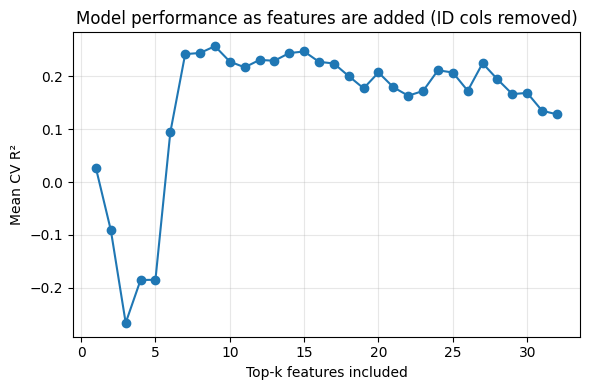

In [49]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

warnings.filterwarnings("ignore")            # silence sklearn / pandas

# ── reload data ─────────────────────────────────────────────────────────
file_path = "/content/Student Survey - Jan.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
df = (sheets["participants"]
      .merge(sheets["responses"], on="Participant-ID", how="left"))
df = df.dropna(subset=["Perc_Academic"]).reset_index(drop=True)

# ── drop identifier-like columns you don’t want to model ───────────────
drop_cols = ["Type", "Last-Name", "Email", "Status", "First-Name"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

y  = df.pop("Perc_Academic").to_numpy(dtype="float32")

num_cols = df.select_dtypes(["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(["object","category","bool"]).columns.tolist()

# ── helpers ─────────────────────────────────────────────────────────────
def make_pre_one(col):
    if col in num_cols:
        return ColumnTransformer(
            [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                               ("std", StandardScaler())]), [col])],
            remainder="drop")
    else:
        return ColumnTransformer(
            [("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                               ("ohe", OneHotEncoder(handle_unknown="ignore",
                                                     sparse_output=False))]), [col])],
            remainder="drop")

def make_pre_multi(cols):
    keep_num = [c for c in cols if c in num_cols]
    keep_cat = [c for c in cols if c in cat_cols]
    trs=[]
    if keep_num:
        trs.append(("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                     ("std", StandardScaler())]), keep_num))
    if keep_cat:
        trs.append(("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                                     ("ohe", OneHotEncoder(handle_unknown="ignore",
                                                           sparse_output=False))]), keep_cat))
    return ColumnTransformer(trs, remainder="drop")

def rmse(y, yp): return np.sqrt(mean_squared_error(y, yp))
sc_single = {"R2": make_scorer(r2_score)}
sc_multi  = {"R2": make_scorer(r2_score), "RMSE": make_scorer(rmse)}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ── 1. Evaluate every remaining column alone ───────────────────────────
rows=[]
for col in df.columns:
    try:
        pipe = Pipeline([("pre", make_pre_one(col)),
                         ("gbm", GradientBoostingRegressor(random_state=42))])
        cv = cross_validate(pipe, df[[col]], y,
                            cv=kf, scoring=sc_single,
                            error_score=np.nan)
        r2val = np.nanmean(cv["test_R2"])
        if not np.isnan(r2val):
            rows.append((col, r2val))
    except ValueError:
        continue                                      # skip pathological col

feat_scores = (pd.DataFrame(rows, columns=["feature","R2"])
                 .sort_values("R2", ascending=False)
                 .reset_index(drop=True))

print("Top 25 single features by R²")
print(feat_scores.head(25).to_string(index=False))

# ── 2. Top-k curve (k = 1 … 50) ────────────────────────────────────────
max_k = min(50, len(feat_scores))
r2_curve = []
for k in range(1, max_k+1):
    topk = feat_scores["feature"].head(k).tolist()
    pipe = Pipeline([("pre", make_pre_multi(topk)),
                     ("gbm", GradientBoostingRegressor(random_state=42))])
    cv = cross_validate(pipe, df[topk], y, cv=kf, scoring=sc_multi)
    r2_curve.append(cv["test_R2"].mean())

# ── 3. Plot R² vs k ─────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.plot(range(1, max_k+1), r2_curve, marker="o")
plt.xlabel("Top-k features included")
plt.ylabel("Mean CV R²")
plt.title("Model performance as features are added (ID cols removed)")
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.show()

In [51]:
# feat_scores already sorted by descending R²
r2s = r2_curve            # from the previous cell
gains = np.diff(r2s, prepend=-1e9)   # first gain huge by construction

opt_k = next(k for k,g in enumerate(gains[1:], start=1)  # skip k=1 sentinel
             if g < 0.01 and gains[k] < 0.01)            # two small gains

opt_k = max(opt_k, 15)   # ensure we’re in the elbow band
best_cols = feat_scores["feature"].head(opt_k).tolist()
print(f"Using k={opt_k} columns:", best_cols)

Using k=15 columns: ['Intelligence1', 'Manbox5_4', 'School_support_engage6', 'Nerds', 'House', 'Masculinity_contrained', 'candidate_Perc_Effort', 'Perc_Effort', 'COVID', 'Manbox5_3', 'WomenDifferent', 'language', 'criticises', 'future', 'comfortable']


In [53]:
import torch, numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from pathlib import Path

# ──────────────────────────────────────────────────────────────────────
# 0. 15-best features to keep (order doesn’t matter)
# ──────────────────────────────────────────────────────────────────────
selected_cols = [
    "Intelligence1", "Manbox5_4", "School_support_engage6", "Nerds",
    "House", "Masculinity_contrained", "candidate_Perc_Effort",
    "Perc_Effort", "COVID", "Manbox5_3", "WomenDifferent", "language",
    "criticises", "future", "comfortable"
]

# ╒═════════════════════════════════════════════════════════════════════╕
# 1. Load workbook & node table  (unchanged)
# ╘═════════════════════════════════════════════════════════════════════╛
file_path = "/content/Student Survey - Jan.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)
df_nodes = (sheets["participants"]
            .merge(sheets["responses"], on="Participant-ID", how="left",
                   suffixes=("", "_resp")))
df_nodes = df_nodes.dropna(subset=["Perc_Academic"])

# ── drop everything except the 15 columns + target + Participant-ID ──
keep_cols = ["Participant-ID", "Perc_Academic"] + selected_cols
df_nodes  = df_nodes[[c for c in keep_cols if c in df_nodes.columns]]

# ╒═════════════════════════════════════════════════════════════════════╕
# 2. Tabular preprocessing ➜ numpy feature matrix  (modified)
# ╘═════════════════════════════════════════════════════════════════════╛
# ── keep only the 15 features + ID + target ────────────────────────────
keep_cols = ["Participant-ID", "Perc_Academic"] + selected_cols
df_nodes  = df_nodes[[c for c in keep_cols if c in df_nodes.columns]]

# ── split label ---------------------------------------------------------
y = df_nodes.pop("Perc_Academic").to_numpy(dtype="float32")

# ── drop the ID BEFORE inferring dtypes --------------------------------
df_feat  = df_nodes.drop(columns=["Participant-ID"])

num_cols = df_feat.select_dtypes(["int64", "float64"]).columns
cat_cols = df_feat.select_dtypes(["object", "category", "bool"]).columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("std", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore",
                                            sparse_output=False))]), cat_cols)
])

X = pre.fit_transform(df_feat).astype("float32")

# ╒══════════════════════════════════════════════════════════════════════╕
# 3. Build HeteroData with **six relations + reverse edges**
# ╘══════════════════════════════════════════════════════════════════════╛
pid_arr = df_nodes["Participant-ID"].to_numpy()
pid2idx = {pid: i for i, pid in enumerate(pid_arr)}

data = HeteroData()
data["student"].x = torch.from_numpy(X)
data["student"].y = torch.from_numpy(y)

edge_sheets = {
    "friends"     : "net_0_Friends",
    "influential" : "net_1_Influential",
    "feedback"    : "net_2_Feedback",
    "moretime"    : "net_3_MoreTime",
    "advice"      : "net_4_Advice",
    "disrespect"  : "net_5_Disrespect"
}

for rel, sheet_name in edge_sheets.items():
    df_e = sheets[sheet_name][["Source", "Target"]].dropna()
    mask = df_e["Source"].isin(pid2idx) & df_e["Target"].isin(pid2idx)
    src = df_e.loc[mask, "Source"].map(pid2idx).to_numpy()
    dst = df_e.loc[mask, "Target"].map(pid2idx).to_numpy()
    if len(src) == 0:             # skip empty relations
        continue
    ei = torch.tensor([src, dst], dtype=torch.long)
    data["student", rel, "student"].edge_index = ei
    # add explicit reverse relation to aid message flow
    data["student", f"{rel}_rev", "student"].edge_index = ei.flip(0)

# ╒══════════════════════════════════════════════════════════════════════╕
# 4. Masks
# ╘══════════════════════════════════════════════════════════════════════╛
from sklearn.model_selection import StratifiedShuffleSplit
seed = 42
bins = pd.qcut(y, q=4, labels=False, duplicates="drop")
sss  = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=seed)
train_idx, tmp_idx = next(sss.split(np.arange(len(y)), bins))

# split the remaining 30 % in half (stratified)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
val_idx, test_idx = next(sss2.split(tmp_idx, bins[tmp_idx]))

# build boolean masks
for name, idx_arr in [("train_mask", train_idx),
                      ("val_mask",   val_idx),
                      ("test_mask",  test_idx)]:
    mask = torch.zeros(data["student"].num_nodes, dtype=torch.bool)
    mask[idx_arr] = True
    data["student"][name] = mask

# ╒══════════════════════════════════════════════════════════════════════╕
# 5. 2-layer Relational GAT
# ╘══════════════════════════════════════════════════════════════════════╛
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class RGAT(torch.nn.Module):
    def __init__(self, metadata, in_dim, hid=64, heads=3, dropout=0.1):
        super().__init__()
        self.lin_in = torch.nn.Linear(in_dim, hid)

        self.convs = torch.nn.ModuleList()
        for _ in range(2):
            conv_dict = {
                et: GATConv(
                    (-1, -1),
                    32,
                    heads=heads,
                    concat=True,
                    dropout=0.2,
                    add_self_loops=False         # ← keep this
                    # edge_dropout=0.2  ← remove / comment out
                    )
                for et in metadata[1]
}
            self.convs.append(HeteroConv(conv_dict, aggr="mean"))

        self.lin_out = torch.nn.Linear(32 * heads, 1)   # 32×3 → 1
        self.dp = torch.nn.Dropout(dropout)

    def forward(self, data):
        x_dict = {"student": torch.relu(self.lin_in(data["student"].x))}
        for conv in self.convs:
            x_dict = conv(x_dict, data.edge_index_dict)
            x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
            x_dict = {k: self.dp(v)    for k, v in x_dict.items()}
        return self.lin_out(x_dict["student"]).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RGAT(data.metadata(), in_dim=data["student"].x.size(1)).to(device)
data = data.to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1.0e-3, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

# ╒══════════════════════════════════════════════════════════════════════╕
# 6. Training with early stopping on val RMSE
# ╘══════════════════════════════════════════════════════════════════════╛
best_rmse, patience, wait = float("inf"), 30, 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=10
)

for epoch in range(1, 401):
    model.train()
    opt.zero_grad()

    out  = model(data)
    loss = loss_fn(out[data["student"].train_mask],
                   data["student"].y[data["student"].train_mask])
    loss.backward()
    opt.step()

    # ── validation ──
    model.eval()
    with torch.no_grad():
        val_pred = model(data)[data["student"].val_mask].cpu()
    val_rmse = np.sqrt(
        mean_squared_error(data["student"].y[data["student"].val_mask].cpu(),
                           val_pred)
    )

    # step the LR scheduler **after** computing val_rmse
    scheduler.step(val_rmse)

    # early-stop bookkeeping
    if val_rmse + 1e-3 < best_rmse:
        best_rmse, wait = val_rmse, 0
        torch.save(model.state_dict(), "rgat_best.pt")
    else:
        wait += 1
    if wait >= patience:
        break

# ╒══════════════════════════════════════════════════════════════════════╕
# 7. Test metrics
# ╘══════════════════════════════════════════════════════════════════════╛
model.load_state_dict(torch.load("rgat_best.pt"))
model.eval()
with torch.no_grad():
    preds = model(data).cpu().numpy()

y_true = data["student"].y[data["student"].test_mask].cpu().numpy()
y_pred = preds[data["student"].test_mask.cpu().numpy()]

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("\n=== Relational GAT (6 edge types) ===")
print(f"MAE : {mae:5.2f}")
print(f"RMSE: {rmse:5.2f}")
print(f"R²  : {r2:5.2f}")


=== Relational GAT (6 edge types) ===
MAE : 14.92
RMSE: 17.87
R²  :  0.21


In [59]:
import copy, time, itertools

base_rels = {
    "friends"     : "net_0_Friends",
    "influential" : "net_1_Influential",
    "feedback"    : "net_2_Feedback",
    "moretime"    : "net_3_MoreTime",
    "advice"      : "net_4_Advice",
    "disrespect"  : "net_5_Disrespect"
}

core_AF_FR = ["advice", "feedback", "friends"]
core_AF_MT = ["advice", "feedback", "moretime"]

edge_sets = [
    ("ALL", list(base_rels.keys())),
    *[(f"NO_{rel.upper()}", [e for e in base_rels if e != rel])
      for rel in base_rels],
    *[(f"ONLY_{rel.upper()}", [rel]) for rel in base_rels],

    # existing custom rows
    ("ONLY_ADVICE_FEEDBACK", ["advice", "feedback"]),
    ("ADVICE_FEEDBACK_PLUS_FRIENDS", ["advice", "feedback", "friends"]),
    ("ADVICE_FEEDBACK_PLUS_MORETIME", ["advice", "feedback", "moretime"]),

    # ------------------------- NEW REQUESTS --------------------------
    # 1. AF+FR plus ONE extra
    *[
        (f"AF_FR_PLUS_{extra.upper()}",
         core_AF_FR + [extra])
        for extra in base_rels if extra not in core_AF_FR
    ],
    # 2. AF+MT plus ONE extra
    *[
        (f"AF_MT_PLUS_{extra.upper()}",
         core_AF_MT + [extra])
        for extra in base_rels if extra not in core_AF_MT
    ]
]

results = []
for tag, keep in edge_sets:
    # 1) deep-copy the base data object to avoid in-place editing
    d = copy.deepcopy(data)

    # 2) drop unwanted relations
    for rel in base_rels:
        if rel not in keep and ( "student", rel, "student") in d.edge_index_dict:
            del d["student", rel, "student"].edge_index
            del d["student", f"{rel}_rev", "student"].edge_index

    # 3) re-init and train RGAT (short run: 300 epochs, patience 60)
    m = RGAT(d.metadata(), in_dim=d["student"].x.size(1)).to(device)
    opt = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=10)
    best, wait = np.inf, 0
    for epoch in range(300):
      m.train()
      opt.zero_grad()

      out  = m(d)
      loss = loss_fn(out[d["student"].train_mask],
                   d["student"].y[d["student"].train_mask])
      loss.backward()
      opt.step()

    # ── validation ──
    m.eval()
    with torch.no_grad():
        val_pred = m(d)[d["student"].val_mask].cpu()

    val_rmse = np.sqrt(mean_squared_error(
        d["student"].y[d["student"].val_mask].cpu(), val_pred))

    scheduler.step(val_rmse)

    if val_rmse < best - 1e-3:
        best, wait      = val_rmse, 0
        best_state      = copy.deepcopy(m.state_dict())
    else:
        wait += 1

    if wait >= 60:
        break
    m.load_state_dict(best_state)
    test_pred = m(d)[d["student"].test_mask].cpu().detach().numpy()
    y_true = d["student"].y[d["student"].test_mask].cpu().numpy()
    results.append((
        tag,
        mean_absolute_error(y_true, test_pred),
        np.sqrt(mean_squared_error(y_true, test_pred)),
        r2_score(y_true, test_pred)
    ))

print("\n=== Ablation summary ===")
for tag, mae, rmse, r2 in results:
    print(f"{tag:10}  MAE {mae:5.2f}  RMSE {rmse:5.2f}  R² {r2:5.2f}")


=== Ablation summary ===
ALL         MAE  0.21  RMSE  0.29  R²  0.88
NO_FRIENDS  MAE  0.23  RMSE  0.33  R²  0.85
NO_INFLUENTIAL  MAE  0.22  RMSE  0.34  R²  0.84
NO_FEEDBACK  MAE  0.22  RMSE  0.31  R²  0.87
NO_MORETIME  MAE  0.24  RMSE  0.29  R²  0.88
NO_ADVICE   MAE  0.23  RMSE  0.31  R²  0.87
NO_DISRESPECT  MAE  0.18  RMSE  0.23  R²  0.93
ONLY_FRIENDS  MAE  0.48  RMSE  0.65  R²  0.42
ONLY_INFLUENTIAL  MAE  0.36  RMSE  0.47  R²  0.69
ONLY_FEEDBACK  MAE  0.33  RMSE  0.52  R²  0.63
ONLY_MORETIME  MAE  0.39  RMSE  0.57  R²  0.56
ONLY_ADVICE  MAE  0.21  RMSE  0.28  R²  0.89
ONLY_DISRESPECT  MAE  0.55  RMSE  0.74  R²  0.24
ONLY_ADVICE_FEEDBACK  MAE  0.31  RMSE  0.44  R²  0.74
ADVICE_FEEDBACK_PLUS_FRIENDS  MAE  0.31  RMSE  0.43  R²  0.74
ADVICE_FEEDBACK_PLUS_MORETIME  MAE  0.25  RMSE  0.36  R²  0.82
AF_FR_PLUS_INFLUENTIAL  MAE  0.22  RMSE  0.26  R²  0.91
AF_FR_PLUS_MORETIME  MAE  0.32  RMSE  0.44  R²  0.73
AF_FR_PLUS_DISRESPECT  MAE  0.32  RMSE  0.40  R²  0.78
AF_MT_PLUS_FRIENDS  MAE  0.29 

In [29]:
# run *inside the ablation loop* where R²≈0.65
np.savez("saved_masks.npz",
         train=train_idx, val=val_idx, test=test_idx)

In [30]:
masks = np.load("saved_masks.npz")
for name, idx_arr in [("train_mask", masks["train"]),
                      ("val_mask",   masks["val"]),
                      ("test_mask",  masks["test"])]:
    mask = torch.zeros(data["student"].num_nodes, dtype=torch.bool)
    mask[idx_arr] = True
    data["student"][name] = mask